# Probabilistic Machine Learning
#### University of Tübingen, Summer Term 2021
## Exercise Sheet 7 
&copy; 2020 Prof. Dr. Philipp Hennig

This sheet is **due on Tuesday 15 June 2021 at 10am sharp.**

---

## GP binary classification
This homework consists of two parts:
1. In the first part you will use the scikit-learn Gaussian process library (as a "black box") for a binary classification problem (for the scikit-learn GP library you can look at https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html). You will play around with a toy dataset to get an intuition on GP binary classification (and hyperparameter optimization) and reflect on high-level questions about Gaussian Processes, Kernels, etc.   (Easy part)
2. In the second part you will implement a binary classification GP yourself. You will apply it to the toy dataset of Part 1 and then to the FashionMNIST dataset to classify T-shirts and trousers.   (Harder part)

# Toy dataset to get a feeling for binary GP classification

In [1]:
# Copied and adapted from: 
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc.html#sphx-glr-download-auto-examples-gaussian-process-plot-gpc-py
# Original Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>


import numpy as np

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, RationalQuadratic, ExpSineSquared

%config InlineBackend.figure_formats = 'svg', 'pdf'
np.random.seed(42)

X_train shape:  (50, 1)
y_train shape:  (50,)
X_test shape:  (50, 1)
y_test shape:  (50,)


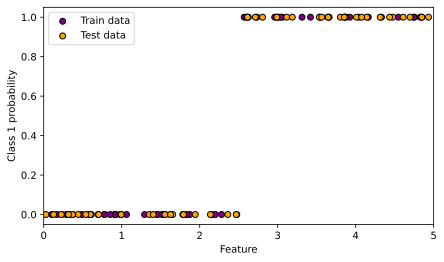

In [2]:
#create a toy dataset
n = 100    #number of data points
train_size = 50

X = np.random.uniform(0,5,n)
y = (X > 2.5).astype(int) #using bool to int casting

X_train = X[0:train_size].reshape(-1,1)
y_train = y[0:train_size]
X_test = X[train_size:n].reshape(-1,1)
y_test = y[train_size:n]
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

#Visualize the data
plt.figure(figsize=(7,4))
plt.scatter(X_train[:, 0], y_train, c='purple', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X_test[:, 0], y_test, c='orange', label="Test data",
            edgecolors=(0, 0, 0))
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.legend(loc="best");

In [3]:
# specify the kernel
RBF_kernel = 1.0 * RBF(length_scale=1.0)
Matern_kernel = 1.0 * Matern(length_scale=1.0, nu=1.5) 
RationalQuadratic_kernel = 1.0 * RationalQuadratic(alpha=0.1, length_scale=1.0) #3 hyperparameters to optimize
ExpSineSquared_kernel = 1.0 * ExpSineSquared(length_scale=1, periodicity=3)     #3 hyperparameters to optimize
DotProduct_kernel = 1 * DotProduct(sigma_0=1.0)

In [4]:
# Specify Gaussian Processes with fixed and optimized hyperparameters

gp_fix = GaussianProcessClassifier(kernel=RBF_kernel,
                                   optimizer=None)
gp_fix.fit(X_train, y_train)

gp_opt = GaussianProcessClassifier(kernel=RBF_kernel)
gp_opt.fit(X_train, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [5]:
# print marginal likelihoods
print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y_train, gp_fix.predict(X_train)),
         accuracy_score(y_train, gp_opt.predict(X_train))))
print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y_train, gp_fix.predict_proba(X_train)[:, 1]),
         log_loss(y_train, gp_opt.predict_proba(X_train)[:, 1])))

Log Marginal Likelihood (initial): -17.169
Log Marginal Likelihood (optimized): -4.625
Accuracy: 0.980 (initial) 1.000 (optimized)
Log-loss: 0.211 (initial) 0.342 (optimized)


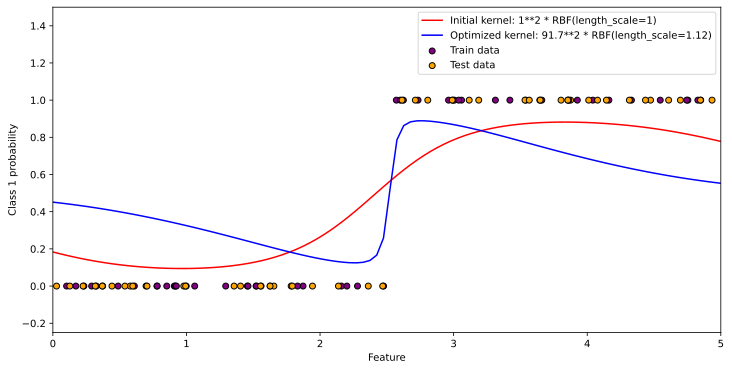

In [6]:
# Plot posteriors
plt.figure(figsize=(12,6))
plt.scatter(X_train[:, 0], y_train, c='purple', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X_test[:, 0], y_test, c='orange', label="Test data",
            edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

<ipython-input-7-2aaf2ceab3d1>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Theta0, Theta1, LML)


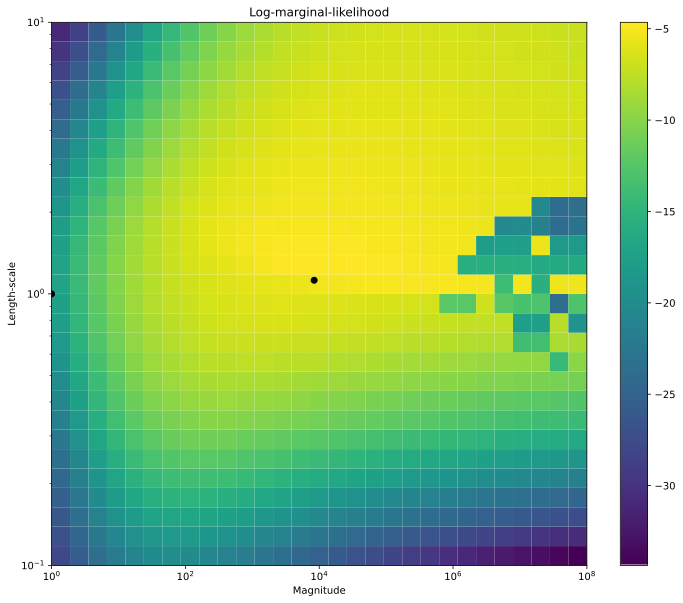

In [7]:
# Plot LML landscape
plt.figure(figsize=(12,10))
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
plt.plot(np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10)
plt.plot(np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1],
         'ko', zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()

## High-level questions:
1. What do the blue and the red line in the posterior plot represent?
2. What is does the log-marginal-likelihood describe?

### One sentence answers are sufficient. Text is sufficient.
1. The red line is a trained GP classifier (using the Laplace approximation) with an RBF kernel, using the given hyperparameters magnitude 1 and lengthscale 1. The blue line is a GP classifier with hyperparameters optimized by maximum log-marginal-likelihood.
2. The log-marginal-likelihood (LML) is the log of the marginal density $p(\boldsymbol y \,\mid\, \boldsymbol X, \boldsymbol\theta)$. The higher the LML is, the higher is the probability of the data coming from the prior distribution, i.e. being generated using $\boldsymbol \theta$.

## Play around with the code:
1. Check out all five different kernels. a) Which one is the best fit?  b) Is any Kernel strictly better than another?
2. Implement a different function for the toy example and test it with all 5 Kernels. Is every Kernel able to fit the problem? The function can be simple, e.g. y = 1 if x < 1 or x > 4, y = 0 else. 

### 1. Test different Kernels. One sentence per answer is sufficient

In [8]:
from tabulate import tabulate

Kernel                      Log-marginal-likelihood
------------------------  -------------------------
RBF_kernel                                 -4.62547
Matern_kernel                              -4.56459
RationalQuadratic_kernel                   -4.61916
ExpSineSquared_kernel                      -4.62313
DotProduct_kernel                          -6.08738


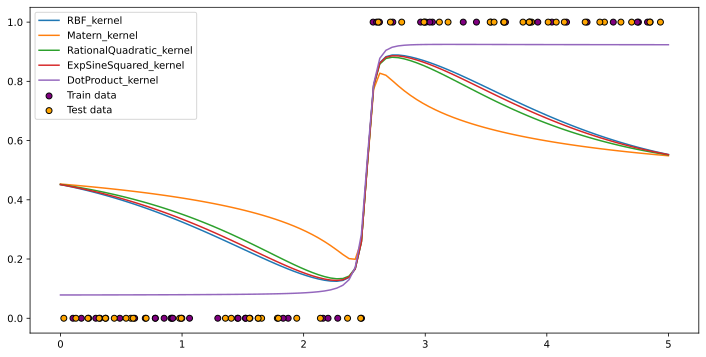

In [9]:
table = []
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X_train[:, 0], y_train, c='purple', label="Train data", edgecolors=(0, 0, 0))
ax.scatter(X_test[:, 0], y_test, c='orange', label="Test data", edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
for kernel, name in zip(
        [RBF_kernel, Matern_kernel, RationalQuadratic_kernel, ExpSineSquared_kernel, DotProduct_kernel],
        ["RBF_kernel", "Matern_kernel", "RationalQuadratic_kernel", "ExpSineSquared_kernel", "DotProduct_kernel"]):
    gp = GaussianProcessClassifier(kernel=kernel)
    gp.fit(X_train, y_train)
    ax.plot(X_, gp.predict_proba(X_[:, np.newaxis])[:, 1], label=name)
    table.append([name, gp.log_marginal_likelihood_value_])
print(tabulate(table, headers=["Kernel", "Log-marginal-likelihood"]))
ax.legend()
plt.show()

The dot product kernel seems to fit the function best, even though the corresponding LML is worst.

### 2. Use a different function

Kernel                      Log-marginal-likelihood
------------------------  -------------------------
RBF_kernel                                 -7.03685
Matern_kernel                              -7.26989
RationalQuadratic_kernel                   -7.03555
ExpSineSquared_kernel                      -6.4769
DotProduct_kernel                         -34.6578


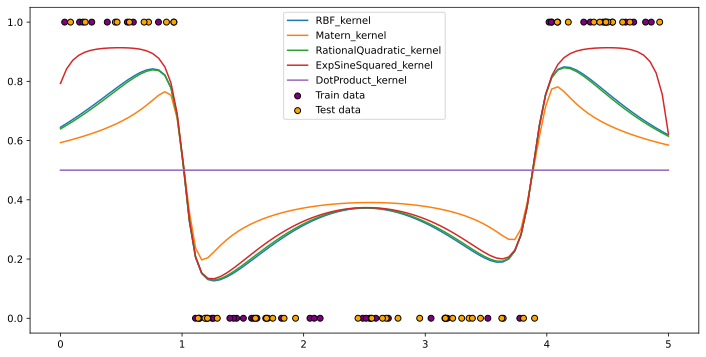

In [10]:
# 2. Copy the relevant parts of the code from above and plot your function with the respective kernel

# New dataset
X = np.random.uniform(0,5,n)
y = ((X < 1) | (X > 4)).astype(int)
X_train2 = X[0:train_size].reshape(-1,1)
y_train2 = y[0:train_size]
X_test2 = X[train_size:n].reshape(-1,1)
y_test2 = y[train_size:n]

table = []
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X_train2[:, 0], y_train2, c='purple', label="Train data", edgecolors=(0, 0, 0))
ax.scatter(X_test2[:, 0], y_test2, c='orange', label="Test data", edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
for kernel, name in zip(
        [RBF_kernel, Matern_kernel, RationalQuadratic_kernel, ExpSineSquared_kernel, DotProduct_kernel],
        ["RBF_kernel", "Matern_kernel", "RationalQuadratic_kernel", "ExpSineSquared_kernel", "DotProduct_kernel"]):
    gp = GaussianProcessClassifier(kernel=kernel)
    gp.fit(X_train2, y_train2)
    ax.plot(X_, gp.predict_proba(X_[:, np.newaxis])[:, 1], label=name)
    table.append([name, gp.log_marginal_likelihood_value_])
print(tabulate(table, headers=["Kernel", "Log-marginal-likelihood"]))
ax.legend()
plt.show()

In this example, the dot product kernel is not able to fit the data. All others are ok, none is great, ExSineSquared seems to be the best fit and also has the highest LML.

# Part 2: implement the GP yourself
Now implement the classification GP yourself. Observe that:
- We only consider binary classification
- Use the RBF kernel as a starter
- Do NOT use np.linalg.inv!!! By now you should know the Cholesky decomposition. 
- You do NOT need to implement an optimizer for the kernel parameters. Just use the values suggested in the toy example and compare with the fixed version of the GP
- Hints: 
    1. Use the knowledge from the lecture on classification GPs with the Laplace approximation. If you want more background read up in the GP book chapter 3: http://www.gaussianprocess.org/gpml/chapters/RW3.pdf
    2. The likelihood in the lecture is calculated for binary classification with [-1, 1] labels. In this example we use [0,1] labels. Do not forget to change the likelihood accordingly before implementing it.
    3. In the GP algorithm you will have to calculate an integral. There are different methods to do that.  For a brute force approximation check out scipy.integrate.quad 
    4. Add a small value on all the diagonal terms, i.e. Kernel + 1e-6*np.eye(X_train.shape[0]). Why is this useful?

Adding a small constant to the diagonal of the kernel is useful in case the kernel matrix is singular.

In [11]:
from scipy.linalg import solve, cholesky, sqrtm
from scipy.integrate import quad_vec
from scipy.stats import norm
from scipy.spatial.distance import cdist

In [12]:
def expquad(x0, x1=None, outputscale=1.0, lengthscale=1.0):
    if x1 is None:
        x1 = x0
    pdists = cdist(x0, x1, metric="euclidean")
    return outputscale ** 2 * np.exp(-(pdists ** 2) / (2.0 * lengthscale ** 2))


class GPClassifier():
    def __init__(self, mean, kernel):
        self.mean = mean
        self.kernel = kernel
    
    def fit(self, X, y, eps=1e-10):
        self.X = X
        self.y = y
        
        # Fit GP classifier using Laplace approximation, Newton method
        m = self.mean(X)
        K = self.kernel(X) + 1e-6*np.eye(len(y))
        f = m.copy()
        y_ = 2*y - 1    # Data is 0,1 instead of -1,1
        converged = False
        while not converged:
            r = (y_ + 1)/2 - sigmoid(f)
            W = np.diag(sigmoid(f) * (1 - sigmoid(f)))    # negative Hessian of log-likelihood
            g = r - solve(K, f - m, assume_a='pos')       # gradient of log-likelihood
            W_sqrt = sqrtm(W)
            B = np.eye(len(y)) + W_sqrt @ K @ W_sqrt
            delta = -K @ g + K @ W_sqrt @ solve(B, W_sqrt @ K @ g, assume_a='pos')
            f -= delta
            converged = delta @ delta < eps**2

        self.W_sqrt, self.B, self.r = W_sqrt, B, r
    
    def predict(self, x):
        # For loop far too slow for Fashion MNIST dataset..
        pi = np.empty(len(x))
        R = cholesky(self.B, lower=True)
        f = self.kernel(x, self.X) @ self.r
        s = solve(R, self.W_sqrt @ self.kernel(self.X, x))
        v = np.diag(self.kernel(x) - s.T@s)
        pi, *_ = quad_vec(lambda z: sigmoid(z) * norm.pdf(z, loc=f, scale=np.sqrt(v)).flatten(), -np.inf, np.inf)
        return pi

def sigmoid(f):
    return 1 / (1 + np.exp(-f))

<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))


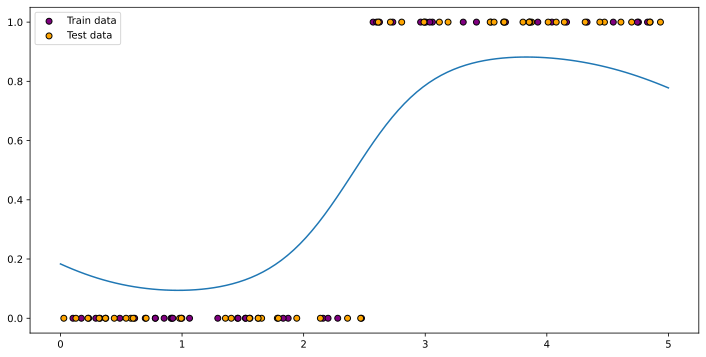

In [13]:
mean = lambda X: np.zeros(len(X))
kernel = expquad
gp = GPClassifier(mean, kernel)
gp.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X_train[:, 0], y_train, c='purple', label="Train data", edgecolors=(0, 0, 0))
ax.scatter(X_test[:, 0], y_test, c='orange', label="Test data", edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
ax.plot(X_, gp.predict(X_[:, np.newaxis]))
ax.legend()
plt.show()

## Testcase 1: reuse the framework from the toy example
Apply the GP you implemented to the given framework from the toy example in Part 1.
- Make sure that you get similar results to the scikit-learn off-the-shelf GP
- Implement one additional Kernel (Matern, DotProduct, RationalQuadratic, ExpSineSquared or another one you choose yourself)

In [14]:
def ratquad(x0, x1=None, lengthscale=1.0, alpha=0.1):
    if x1 is None:
        x1 = x0

    d = cdist(x0, x1)**2
    return (1 + d/(2 * alpha * lengthscale**2)) ** (-alpha)

<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))
<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))


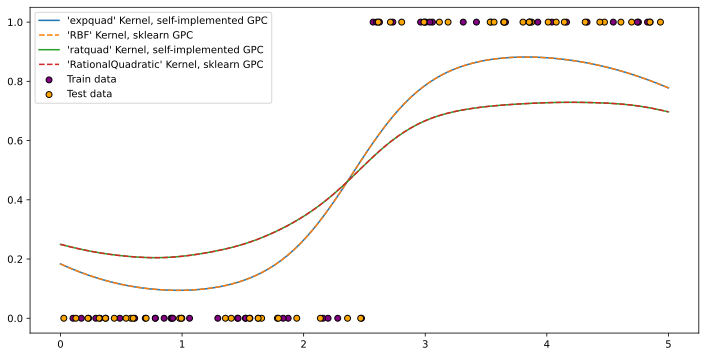

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(X_train[:, 0], y_train, c='purple', label="Train data", edgecolors=(0, 0, 0))
ax.scatter(X_test[:, 0], y_test, c='orange', label="Test data", edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)

# Expquad kernel, self-implemented GP
mean = lambda X: np.zeros(len(X))
gp = GPClassifier(mean, expquad)
gp.fit(X_train, y_train)
ax.plot(X_, gp.predict(X_[:, np.newaxis]), label="'expquad' Kernel, self-implemented GPC")

plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], '--', label="'RBF' Kernel, sklearn GPC")

# Ratquad kernel, self-implemented GP
gp = GPClassifier(mean, ratquad)
gp.fit(X_train, y_train)
ax.plot(X_, gp.predict(X_[:, np.newaxis]), label="'ratquad' Kernel, self-implemented GPC")

gp = GaussianProcessClassifier(RationalQuadratic_kernel, optimizer=None)
gp.fit(X_train, y_train)
ax.plot(X_, gp.predict_proba(X_[:, np.newaxis])[:, 1], '--', label="'RationalQuadratic' Kernel, sklearn GPC")

ax.legend()
plt.show()

## Testcase 2: Fashion MNIST T-shirt vs trousers
Now apply your GP to the Fashion MNIST dataset to classify T-shirts and trousers.
- We use class 0 (Tshirt/top) and class 1 (trousers) as the two classes for the binary classification
- The nasty data wrangling stuff has already been done for you (see below)
- We use the first 5000 samples to train our kernel
- Your task is to apply your own implementation to this dataset and report your results

In [16]:
import torch, torchvision
import torchvision.transforms as transforms
torch.manual_seed(42)

In [17]:
# data wrangling: get the first two classes for FMNIST
FMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


FMNIST_train = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=True,
        download=False,
        transform=FMNIST_transform)


FMNIST_test = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=False,
        download=False,
        transform=FMNIST_transform)

def get_subset_FMNIST(classes=[0,1], dataset=FMNIST_train):
    
    dataset.targets = dataset.targets.clone().detach()
    idx = torch.zeros(dataset.targets.size()).byte()
    for c in classes:
        idx += (dataset.targets==c).byte()
    dataset.targets= dataset.targets[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]
    
    #remap all classes to list of ints starting at 1
    map_dict = dict()
    for i, c in enumerate(classes):
        map_dict[c] = i
    
    for i, t in enumerate(dataset.targets):
        dataset.targets[i] = map_dict[t.item()]
    
    return(dataset.data, dataset.targets)

classes = [0,1]
FMNIST_train.data, FMNIST_train.targets = get_subset_FMNIST(classes=classes, dataset=FMNIST_train)
FMNIST_test.data, FMNIST_test.targets = get_subset_FMNIST(classes=classes, dataset=FMNIST_test)
print(len(FMNIST_train.targets))
print(FMNIST_train.targets[:10])
print(len(FMNIST_test.targets))
print(FMNIST_test.targets[:10])

12000
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1])
2000
tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 1])


<ipython-input-17-3f8ff8a2eb3b>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/aten/src/ATen/native/IndexingUtils.h:25.)
  dataset.targets= dataset.targets[idx]


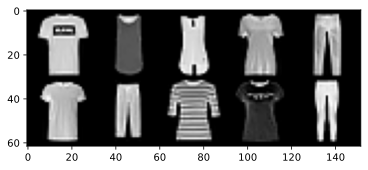

In [18]:
# have a look at them to verify they are only 
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = FMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))

In [19]:
# further data wrangling
X_train = FMNIST_train.data[:5000].view(-1, 28*28)
print(X_train.shape)
y_train = FMNIST_train.targets[:5000].view(-1)
print(y_train[:10])

X_test = FMNIST_test.data.view(-1, 28*28)
print(X_test.shape)
y_test = FMNIST_test.targets.view(-1)
print(y_test[:10])

#normalize the data between [-1,1]
X_train = (X_train.float() - 128) / 128
X_test = (X_test.float() - 128) / 128

X_train, X_test = X_train.numpy(), X_test.numpy()
y_train, y_test = y_train.numpy(), y_test.numpy()

torch.Size([5000, 784])
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1])
torch.Size([2000, 784])
tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 1])


In [20]:
#The nasty data wrangling stuff has been done for you. 
#TODO: test which kernel works for this problem?

In [21]:
from tqdm.notebook import tqdm

In [24]:
table = []
# ExpSineSquared produces non-positive definite matrix for some reason...
for kernel, name in tqdm(zip(
        [DotProduct_kernel, RBF_kernel, Matern_kernel, RationalQuadratic_kernel],
        ["DotProduct", "RBF", "Matern", "RationalQuadratic"])):
    gp = GPClassifier(mean, kernel)    # Self-implemented GP
    gp.fit(X_train, y_train)
    pred_train = gp.predict(X_train)
    pred_test = gp.predict(X_test)
    table.append([name,
                  accuracy_score(y_train, np.round(pred_train)), log_loss(y_train, pred_train),
                  accuracy_score(y_test, np.round(pred_test)), log_loss(y_test, pred_test)])

print(tabulate(table, headers=["Kernel", "Acc. (training)", "Log-loss (training)", "Acc. (test)", "Log-loss (test)"]))

<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))
<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))
<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))
<ipython-input-12-2b52c61d4866>:50: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-f))



Kernel               Acc. (training)    Log-loss (training)    Acc. (test)    Log-loss (test)
-----------------  -----------------  ---------------------  -------------  -----------------
DotProduct                    0.9996              0.0292039         0.988           0.0476468
RBF                           1                   0.536557          0.9655          0.692806
Matern                        1                   0.534468          0.9855          0.689767
RationalQuadratic             0.9796              0.114608          0.974           0.127395


In this case, the DotProduct kernel seems to perform best.